<a href="https://colab.research.google.com/github/smqhw/kdm1/blob/main/icp10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

!wget https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv

--2021-04-13 19:25:17--  https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8480236 (8.1M) [text/plain]
Saving to: ‘women_clothing_review.csv’

women_clothing_revi 100%[===================>]   8.09M  --.-KB/s    in 0.1s    

2021-04-13 19:25:18 (67.3 MB/s) - ‘women_clothing_review.csv’ saved [8480236/8480236]



In [5]:
df = pd.read_csv('women_clothing_review.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
df.shape

(23486, 11)

In [7]:
df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0', ], axis=1)
df.dropna(inplace=True)
print(df.shape)
df

(22628, 8)


,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,1104,34,I was very happy to snag this dress at such a ...,5,1,General Petite,Dresses,Dresses
23482,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,General Petite,Tops,Knits
23483,1104,31,"This fit well, but the top was very see throug...",3,0,General Petite,Dresses,Dresses
23484,1084,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses


In [8]:
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive


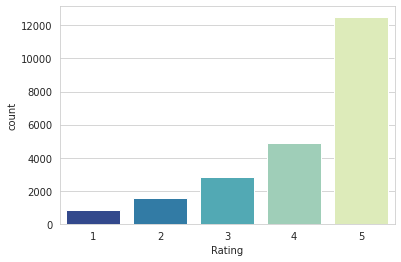

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

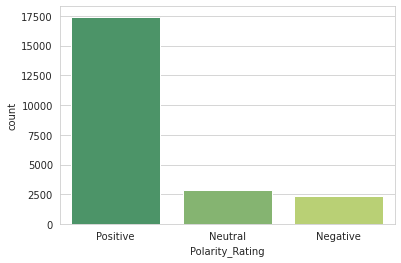

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

In [11]:
df_Positive = df[df['Polarity_Rating'] == 'Positive'][0:6000]
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

In [12]:
df_Positive.shape

(6000, 9)

In [13]:
df_Neutral.shape

(2823, 9)

In [14]:
df_Negative.shape

(2370, 9)

In [15]:
df_Neutral_over = df_Neutral.sample(6000, replace=True)
df_Negative_over = df_Negative.sample(6000, replace=True)

In [16]:
df_Neutral_over.shape

(6000, 9)

In [18]:
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [17]:
df.shape

(22628, 9)

In [19]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [20]:
df['review'] = df['Review Text'].apply(get_text_processing)
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating,review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...
6,858,39,I aded this in my basket at hte last mintue to...,5,1,General Petite,Tops,Knits,Positive,aded basket hte last mintue see would look lik...


In [21]:
df = df[['review', 'Polarity_Rating']]
df.head()

,review,Polarity_Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive
6,aded basket hte last mintue see would look lik...,Positive


In [22]:
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,review,Negative,Neutral,Positive
0,Absolutely wonderful silky sexy comfortable,0,0,1
1,Love dress sooo pretty happened find store im ...,0,0,1
3,love love love jumpsuit fun flirty fabulous ev...,0,0,1
4,shirt flattering due adjustable front tie perf...,0,0,1
6,aded basket hte last mintue see would look lik...,0,0,1


In [23]:
X = df['review'].values
y = df.drop('review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [48]:
X_train

array(['buy bought olive green color loved bought navy blue fit true size im size 4 bought 27 comfortable make bum look good prefer skirts dresses shorter pants like gauchos instead shorty shorts summer something wear time warm weather wear casually dress',
       'anorak perfection perfect weight color style super easy wear found fit true size oversized im 53 130lbs 32d average buildframe took size small comfortably wear long sleeved shirt underneath even thin sweater think xs would tight shouldersbust fits perfectly love inner drawstrings pull give little shape got 30 promo',
       'top thickness comfort sweatshirt artistic flair figure flattering unique cut works well im petite large wish little roomier 10 lbs lighter stretchy really love wearing color rich indigo slightly worn look adds texture dimension',
       ...,
       'really wanted love dress like lacing neck dress high quality comfortable runs large also sleeves model gathered sleeves dress received hang loose big wrist g

In [24]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [25]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [26]:
print(X_train)

  (0, 1951)	1
  (0, 1678)	3
  (0, 7070)	1
  (0, 4772)	1
  (0, 2417)	1
  (0, 6159)	1
  (0, 6780)	1
  (0, 1549)	1
  (0, 4171)	1
  (0, 10857)	1
  (0, 9266)	2
  (0, 5264)	1
  (0, 256)	1
  (0, 2467)	1
  (0, 6259)	1
  (0, 1872)	1
  (0, 6096)	1
  (0, 4684)	1
  (0, 7849)	1
  (0, 9331)	1
  (0, 3486)	1
  (0, 9119)	1
  (0, 7331)	1
  (0, 5989)	1
  (0, 4569)	1
  :	:
  (14399, 8729)	1
  (14399, 6172)	1
  (14399, 1044)	1
  (14399, 1317)	1
  (14399, 10533)	1
  (14399, 3174)	1
  (14399, 10839)	1
  (14399, 5728)	1
  (14399, 10867)	1
  (14399, 7809)	1
  (14399, 6796)	1
  (14399, 5550)	1
  (14399, 2155)	1
  (14399, 7757)	1
  (14399, 1148)	1
  (14399, 3875)	1
  (14399, 4285)	1
  (14399, 1271)	1
  (14399, 1300)	1
  (14399, 5481)	1
  (14399, 9754)	1
  (14399, 6562)	1
  (14399, 5107)	1
  (14399, 4721)	1
  (14399, 8948)	1


In [27]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [28]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
model = Sequential()
        
model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.6))
        
model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.6))
        
model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=10000,activation='relu'))
model.add(Dropout(0.6))


model.add(Dense(units=3, activation='softmax'))
        
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [33]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
57/57 [==============================] - 13s 176ms/step - loss: 0.9058 - accuracy: 0.5249 - val_loss: 0.4520 - val_accuracy: 0.8297
Epoch 2/100
57/57 [==============================] - 10s 169ms/step - loss: 0.2367 - accuracy: 0.9184 - val_loss: 0.3251 - val_accuracy: 0.8989
Epoch 3/100
57/57 [==============================] - 10s 170ms/step - loss: 0.0521 - accuracy: 0.9849 - val_loss: 0.3911 - val_accuracy: 0.8894
Epoch 4/100
57/57 [==============================] - 10s 170ms/step - loss: 0.0176 - accuracy: 0.9952 - val_loss: 0.5460 - val_accuracy: 0.8942
Epoch 00004: early stopping


In [34]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

57/57 [==============================] - 1s 23ms/step - loss: 0.5460 - accuracy: 0.8942
Test accuracy: 0.8941666483879089


In [36]:
preds = model.predict(X_test)
preds

array([[1.3323141e-10, 3.9860630e-09, 1.0000000e+00],
       [3.3020221e-03, 9.9124700e-01, 5.4510343e-03],
       [1.6240870e-10, 9.9999988e-01, 1.1306097e-07],
       ...,
       [9.9999881e-01, 2.2200753e-08, 1.1683589e-06],
       [9.9307775e-01, 2.0306667e-03, 4.8916042e-03],
       [9.9998581e-01, 2.6858174e-07, 1.3985544e-05]], dtype=float32)